
<center>

#**Taller 2:** Modelos de riesgo de crédito.

</center>
<center>

---
Técnicas de Aprendizaje Estadístico 


---
**Profesor:**

Juan David Ospina Arango

---
</center>

**Objetivos:**

*   Cree y valide un modelo de probabilidad de incumplimiento para toda la base
*   Represente este modelo con una scorecard
*   Analice qué variables hacen más riesgosa a una persona


## Librerías y carga de los datos

In [ ]:
#Librerías para los datos en Google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth 
from oauth2client.client import GoogleCredentials
#Librerías para gráficos y procesamiento de los datos 
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
#Librerias para modelos 
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [ ]:
#La base de datos se encuentra en el siguiente link 

#https://drive.google.com/file/d/166vL6y2JgEF1L7ys7JoeAEIxSBcUj26H/view?usp=sharing

In [ ]:
#tiene que autentificar con la misma cuenta que abrio el colab <<<<<<<<<<<<<<------------------------------
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '166vL6y2JgEF1L7ys7JoeAEIxSBcUj26H' #<-- You add in here the id from you google drive file, you can find it
#el id del link de arriba

download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('loan_data_2007_2014.csv')
df  = pd.read_csv("loan_data_2007_2014.csv").copy()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Exploración de los datos 

In [ ]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminamos las variables con mas del 80% de los datos nulos y aquellas variables que sabemos que no aportan nada al modelo como la identificación, el titulo, la url, etc.

In [ ]:
# drop columns with more than 80% null values
df.dropna(thresh = df.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

#drop all redundant and forward-looking columns
df.drop(columns = [ 'id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title',
                          'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
                          'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

df.drop(columns = ["out_prncp","total_pymnt","total_rec_int","last_pymnt_amnt"], inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  loan_status                  466285 non-null  object 
 13 

Analizamos nuestra variable de interés "loan_status" 

In [ ]:
# explore the unique values in loan_status column
df['loan_status'].value_counts(normalize = True).to_latex()

'\\begin{tabular}{lr}\n\\toprule\n{} &  loan\\_status \\\\\n\\midrule\nCurrent                                            &     0.480878 \\\\\nFully Paid                                         &     0.396193 \\\\\nCharged Off                                        &     0.091092 \\\\\nLate (31-120 days)                                 &     0.014798 \\\\\nIn Grace Period                                    &     0.006747 \\\\\nDoes not meet the credit policy. Status:Fully Paid &     0.004263 \\\\\nLate (16-30 days)                                  &     0.002612 \\\\\nDefault                                            &     0.001784 \\\\\nDoes not meet the credit policy. Status:Charged... &     0.001632 \\\\\n\\bottomrule\n\\end{tabular}\n'

Definimos entre buenos y malos (1,0)

In [ ]:
# create a new column based on the loan_status column that will be our target variable
df['good_bad'] = np.where(df.loc[:, 'loan_status'].isin(['Charged Off', 'Default',
                                                                       'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)

# Drop the original 'loan_status' column
df.drop(columns = ['loan_status'], inplace = True)

df['good_bad'].value_counts(normalize = True)

1    0.890693
0    0.109307
Name: good_bad, dtype: float64

Separamos nuestra variable de interés del resto de datos y dividimos los datos para el entrenamiento y para la prueba. 

In [ ]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = df.drop('good_bad', axis = 1)
y = df['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

# hard copy the X datasets to avoid Pandas' SetttingWithCopyWarning when we play around with this data later on.
# this is currently an open issue between Pandas and Scikit-Learn teams
X_train, X_test = X_train.copy(), X_test.copy()

## Data Cleaning 

Corregimos el formato de las variables que son fechas para poder trabajarlas en los modelos 

In [ ]:
# function to clean up the emp_length column, assign 0 to NANs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

'''
function to convert date columns to datetime format and
create a new column as a difference between today and the respective date
'''
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / 
							np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

# apply these functions to X_train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')
emp_length_converter(X_train, 'emp_length')
loan_term_converter(X_train, 'term')

X_train.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,...,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
456615,15000,15000,15000.0,36,8.90,476.30,A,7.0,MORTGAGE,80000.0,...,1,INDIVIDUAL,0.0,0.0,143586.0,35100.0,296.0,79.0,62.0,55.0
451541,8000,8000,8000.0,60,18.25,204.24,D,10.0,OWN,44000.0,...,1,INDIVIDUAL,0.0,0.0,180443.0,41300.0,301.0,79.0,55.0,55.0
394474,12150,12150,12100.0,60,18.92,314.65,D,3.0,OWN,27000.0,...,1,INDIVIDUAL,0.0,0.0,34197.0,9800.0,359.0,75.0,55.0,55.0
110294,10000,10000,10000.0,36,6.03,304.36,A,3.0,MORTGAGE,33000.0,...,1,INDIVIDUAL,0.0,0.0,77959.0,10100.0,224.0,84.0,59.0,59.0
139343,15825,15825,15825.0,36,12.12,526.53,B,10.0,MORTGAGE,59000.0,...,1,INDIVIDUAL,0.0,0.0,187370.0,32400.0,494.0,87.0,78.0,55.0


## Feature Selection

A continuación, realizaremos la selección de características para identificar las más adecuadas para nuestro problema de clasificación binaria utilizando la prueba de Chi-cuadrado para las características categóricas y el estadístico F de ANOVA para las características numéricas.

In [ ]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

Estadística Chi-squared para Variables categoricas

In [ ]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result


,Feature,p-value
0,grade,0.000000
1,home_ownership,0.000000
2,verification_status,0.000000
3,purpose,0.000000
4,addr_state,0.000000
5,initial_list_status,0.000000
6,pymnt_plan,0.000923
7,application_type,1.000000


ANOVA F-Statistic para variables numericas 

In [ ]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,23513.805570,0.000000e+00
1,total_pymnt_inv,14784.534040,0.000000e+00
2,int_rate,11462.788313,0.000000e+00
3,out_prncp_inv,9633.442129,0.000000e+00
4,mths_since_last_credit_pull_d,7020.218888,0.000000e+00
5,mths_since_issue_d,2816.028871,0.000000e+00
6,inq_last_6mths,2003.820465,0.000000e+00
7,term,1590.811890,0.000000e+00
8,revol_util,931.880533,0.000000e+00
9,dti,863.811228,0.000000e+00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

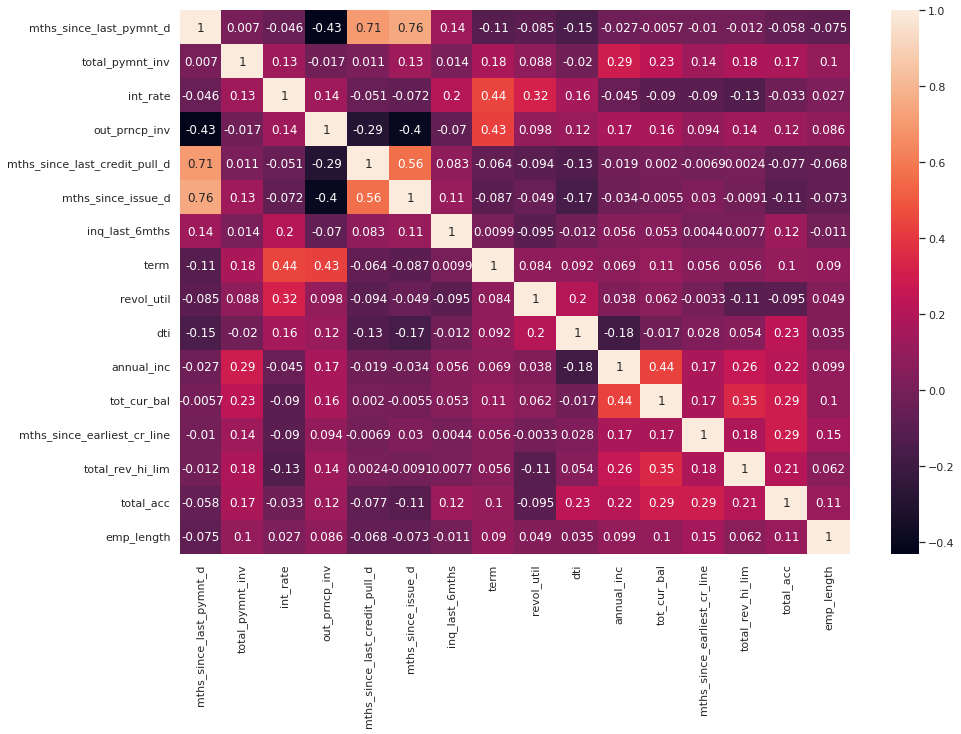

In [ ]:
# save the top 16 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:16,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat, annot=True)
plt.savefig('heatmap.png')
from google.colab import files
files.download("heatmap.png") ;

In [ ]:
# Define a helper function to drop the 4 categorical features with least p-values for chi squared test, 14 numerical features with least F-Statistic
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[16:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   term                           373028 non-null  int64  
 3   int_rate                       373028 non-null  float64
 4   installment                    373028 non-null  float64
 5   grade                          373028 non-null  object 
 6   emp_length                     373028 non-null  float64
 7   home_ownership                 373028 non-null  object 
 8   annual_inc                     373024 non-null  float64
 9   verification_status            373028 non-null  object 
 10  purpose                        373028 non-null  object 
 11  dti                            373028 non-null  float64
 12  inq_last_6mths            

In [ ]:
pd.DataFrame(X_train.dtypes)

,0
loan_amnt,int64
funded_amnt,int64
term,int64
int_rate,float64
installment,float64
grade,object
emp_length,float64
home_ownership,object
annual_inc,float64
verification_status,object


## One-Hot Encoding y actualización de los datos de prueba

Para las variables categoricas

### Dummy variables 

In [ ]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, [ 'grade','home_ownership', 'verification_status', 'purpose'])


### Actualizacion de los datos de prueba

In [ ]:

# update the test data with all functions defined so far
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, [ 'grade','home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the training set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 51 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            373028 non-null  int64  
 1   funded_amnt                          373028 non-null  int64  
 2   term                                 373028 non-null  int64  
 3   int_rate                             373028 non-null  float64
 4   installment                          373028 non-null  float64
 5   grade                                373028 non-null  object 
 6   emp_length                           373028 non-null  float64
 7   home_ownership                       373028 non-null  object 
 8   annual_inc                           373024 non-null  float64
 9   verification_status                  373028 non-null  object 
 10  purpose                              373028 non-null  object 
 11  dti      

## WoE Binning and Feature Engineering

### Análisis del WoEs y IVs de variables discretas

Solo enseñamos 2 casos, el resto los analizamos por aparte para así no alargar la documentación

In [ ]:
# Create copies of the 4 training sets to be preprocessed using WoE
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

# function to calculate WoE and IV of categorical features
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [ ]:
# We set the default style of the graphs to the seaborn style. 
sns.set()
# Below we define a function for plotting WoE across categories that takes 2 arguments: a dataframe and a number.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)    

**"grade"**

In [ ]:
df_temp = woe_discrete(X_train_prepr, 'grade', y_train_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2623,0.721693,0.007032,1893.0,730.0,0.005697,0.017904,-1.144981,NaN,NaN,0.292145
1,F,10606,0.758061,0.028432,8040.0,2566.0,0.024198,0.062932,-0.955774,0.036369,0.189207,0.292145
2,E,28590,0.804477,0.076643,23000.0,5590.0,0.069224,0.137097,-0.683340,0.046416,0.272434,0.292145
3,D,61713,0.845527,0.165438,52180.0,9533.0,0.157049,0.233801,-0.397915,0.041050,0.285425,0.292145
4,C,100342,0.885870,0.268993,88890.0,11452.0,0.267536,0.280865,-0.048620,0.040343,0.349295,0.292145
5,B,109344,0.921422,0.293125,100752.0,8592.0,0.303238,0.210723,0.363975,0.035552,0.412595,0.292145
6,A,59810,0.961361,0.160336,57499.0,2311.0,0.173057,0.056678,1.116232,0.039939,0.752257,0.292145


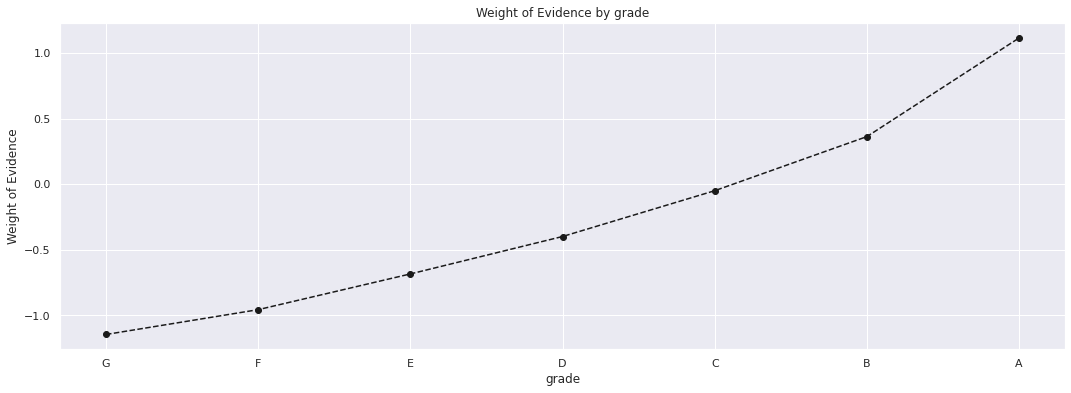

In [ ]:
plot_by_woe(df_temp)

**"home_ownership"**

In [ ]:
df_temp = woe_discrete(X_train_prepr, 'home_ownership', y_train_prepr)
df_temp

,home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OTHER,159,0.792453,0.000426,126.0,33.0,0.000379,0.000809,-0.758081,NaN,NaN,0.02166
1,NONE,41,0.853659,0.000110,35.0,6.0,0.000105,0.000147,-0.334267,0.061206,0.423814,0.02166
2,RENT,150776,0.874052,0.404195,131786.0,18990.0,0.396642,0.465738,-0.160588,0.020393,0.173678,0.02166
3,OWN,33313,0.890343,0.089304,29660.0,3653.0,0.089269,0.089591,-0.003605,0.016292,0.156984,0.02166
4,MORTGAGE,188739,0.904143,0.505965,170647.0,18092.0,0.513604,0.443714,0.146272,0.013800,0.149877,0.02166


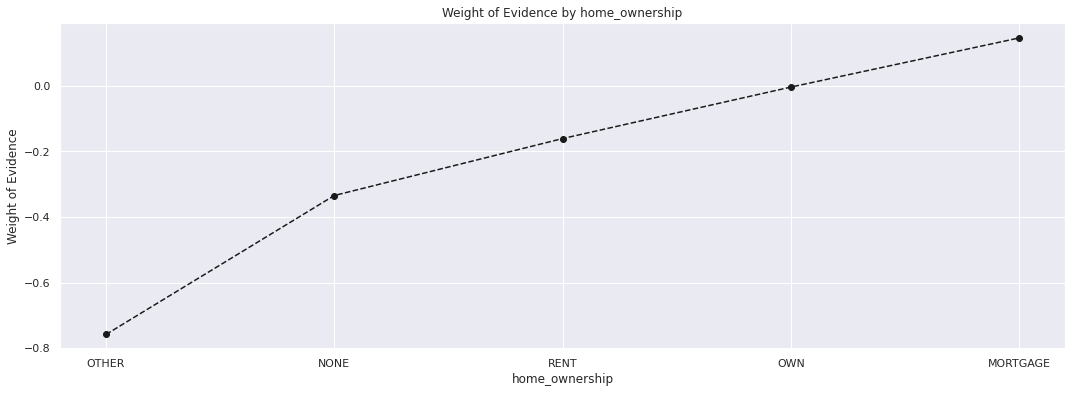

In [ ]:
plot_by_woe(df_temp)

### Análisis del WoEs y IVs de variables numericas

In [ ]:
'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


**"term"**

In [ ]:
df_temp = woe_ordered_continuous(X_train_prepr, 'term', y_train_prepr)
df_temp

,term,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,36,270199,0.903238,0.72434,244054.0,26145.0,0.73454,0.641217,0.135876,NaN,NaN,0.040794
1,60,102829,0.857735,0.27566,88200.0,14629.0,0.26546,0.358783,-0.301254,0.045503,0.43713,0.040794


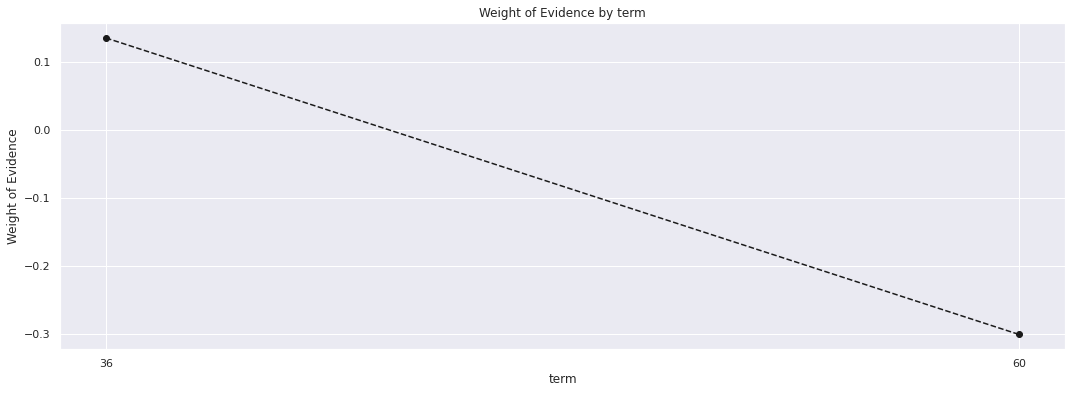

In [ ]:
plot_by_woe(df_temp)

**"int_rate_factor"**

In [ ]:
# fine-classing using the 'cut' method, given the large number of unique values
X_train_prepr['int_rate_factor'] = pd.cut(X_train_prepr['int_rate'], 50)
# Process 'int_rate_factor' column through woe_ordered_continuous and plot_by_woe functions
df_temp = woe_ordered_continuous(X_train_prepr, 'int_rate_factor', y_train_prepr)
df_temp

,int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.399, 5.833]",776,0.962629,0.002080,747.0,29.0,0.002248,0.000711,1.150914,NaN,NaN,0.346603
1,"(5.833, 6.246]",8408,0.979305,0.022540,8234.0,174.0,0.024782,0.004267,1.759117,0.016677,0.608203,0.346603
2,"(6.246, 6.658]",7842,0.971181,0.021023,7616.0,226.0,0.022922,0.005543,1.419616,0.008125,0.339500,0.346603
3,"(6.658, 7.071]",1777,0.969612,0.004764,1723.0,54.0,0.005186,0.001324,1.364983,0.001569,0.054633,0.346603
4,"(7.071, 7.484]",3186,0.976146,0.008541,3110.0,76.0,0.009360,0.001864,1.613790,0.006534,0.248806,0.346603
5,"(7.484, 7.897]",12590,0.963781,0.033751,12134.0,456.0,0.036520,0.011184,1.183419,0.012365,0.430371,0.346603
6,"(7.897, 8.31]",9680,0.949483,0.025950,9191.0,489.0,0.027663,0.011993,0.835762,0.014297,0.347656,0.346603
7,"(8.31, 8.722]",6666,0.965047,0.017870,6433.0,233.0,0.019362,0.005714,1.220303,0.015563,0.384540,0.346603
8,"(8.722, 9.135]",9578,0.938923,0.025676,8993.0,585.0,0.027067,0.014347,0.634735,0.026124,0.585568,0.346603
9,"(9.135, 9.548]",6563,0.965565,0.017594,6337.0,226.0,0.019073,0.005543,1.235771,0.026642,0.601036,0.346603


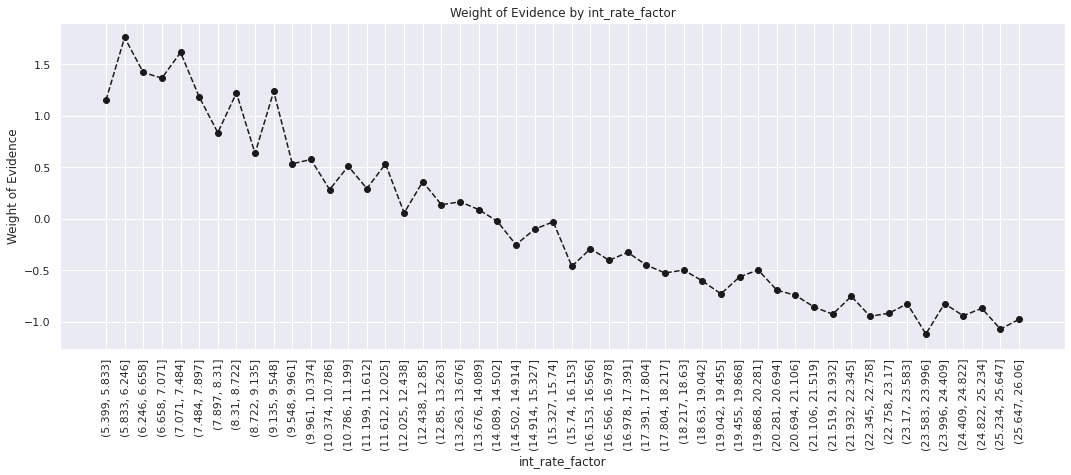

In [ ]:
plot_by_woe(df_temp, 90)

### WoE Binning

In [ ]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780',
                  'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']	

# custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new
        

## Entrenamiento del modelo 

In [ ]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(373028, 51)
(373028,)
(93257, 51)
(93257,)


In [ ]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7147
Gini: 0.4293


In [ ]:
# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
0            5000         5000           4975.0   36 months     10.65   
1            2500         2500           2500.0   60 months     15.27   
2            2400         2400           2400.0   36 months     15.96   
3           10000        10000          10000.0   36 months     13.49   
4            3000         3000           3000.0   60 months     12.69   
...           ...          ...              ...         ...       ...   
466280      18400        18400          18400.0   60 months     14.47   
466281      22000        22000          22000.0   60 months     19.97   
466282      20700        20700          20700.0   60 months     1...
        acc_now_delinq tot_coll_amt  tot_cur_bal  total_rev_hi_lim  
0                  0.0          NaN          NaN               NaN  
1                  0.0          NaN          NaN               NaN  
2           

In [ ]:
# create a summary table
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients'
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table.head(20)

,Feature name,Coefficients
0,Intercept,-1.850463
1,grade:A,1.187734
2,grade:B,0.906924
3,grade:C,0.731165
4,grade:D,0.578035
5,grade:E,0.377329
6,grade:F,0.230648
7,home_ownership:OWN,-0.035009
8,home_ownership:OTHER_NONE_RENT,-0.136284
9,verification_status:Source Verified,-0.092189


## Prediction Time

In [ ]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [ ]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(93257, 2)

In [ ]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head(10)

,y_test_class_actual,y_hat_test_proba
395346,1,0.537477
376583,1,0.839575
297790,1,0.562390
47347,1,0.377425
446772,0,0.322891
415533,1,0.770404
355671,1,0.765598
11223,1,0.473343
411384,1,0.762354
21993,1,0.711522


###Confusion Matrix and AUROC on Test Set

In [ ]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.07122254, 0.03808829],
       [0.30251885, 0.58817033]])

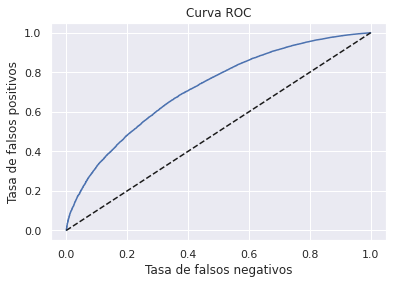

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('Tasa de falsos negativos')
plt.ylabel('Tasa de falsos positivos')
plt.title('Curva ROC');

In [ ]:

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
# print AUROC and Gini
print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
# get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], 
                                                       y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistico')
plt.xlabel('Sensibildad')
plt.ylabel('Precision')
plt.legend()
plt.title('Curva PR');

## Scorecard Development

In [ ]:
# create a new dataframe with one column with values from the 'reference_categories' list
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0

# Concatenates two dataframes
df_scorecard = pd.concat([summary_table, df_ref_categories])
# reset the index
df_scorecard.reset_index(inplace = True)

# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new column that has the imputed calculated Score based scaled from the coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (
	max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept
df_scorecard.loc[0, 'Score - Calculation'] = (
	(df_scorecard.loc[0,'Coefficients'] - min_sum_coef) /
	(max_sum_coef - min_sum_coef
	)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598
df_scorecard

In [ ]:
x= list(df_scorecard['Feature name'])
np.savetxt("variables.csv", x, delimiter =",",fmt ='% s')

### Calculo de los puntajes para todas las observaciones en los datos de prueba

In [ ]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

In [ ]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

In [ ]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(86, 1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

In [ ]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

In [ ]:
#Guardamos estos valores para hacer la implementacion del sitio web
scorecard_scores.tofile('Data.csv', sep = ',')
len(scorecard_scores)

### Fijación de los límites de aprobación de los préstamos

In [ ]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Esto significa que, basándose en el estadístico J de Youden, el umbral de probabilidad ideal es 0,3603, que minimiza el FPR y maximiza el TPR: todas las muestras con una probabilidad predicha superior a este valor deberían clasificarse como en Default y viceversa. 

In [ ]:

# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * 
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

# define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.360324, 0.360326)]

## Comportamiento de la población 

In [ ]:
sns.distplot(y_scores)

In [ ]:
!pip install distfit
from distfit import distfit

# Initialize distfit
dist = distfit()

# Determine best-fitting probability distribution for data
dist.fit_transform(np.array(y_scores))
print(dist.summary)

In [ ]:
print("Puntuacion Minima:", y_scores.min(), "Puntuacion Maxima:", y_scores.max())

In [ ]:
def percentil(score):
  per = score/973*100
  return (per)

percentil(y_scores)

In [ ]:
y_scores.min()